# Introduction
In my [previous blog post](https://www.feststelltaste.de/spotting-co-changing-files/), we've seen how we can identify files that change together in one commit.

In this blog post, we take the analysis to an advanced level:

* We're using a more robust model for determining the similarity of co-changing source code
* We're creating a visualization that let us (to a certain degree) determine the underlying modularization of our software system based on the conjoint changes
* We discuss the result for a concrete software system in detail (with more to come in the upcoming blog posts).

We're using [Python](https://www.python.org/) and [pandas](https://pandas.pydata.org/) as well as some algorithms from [scikit-learn](http://scikit-learn.org/) and the visualization libraries [matplotlib](https://matplotlib.org/) and [pygal](http://www.pygal.org/) for these purposes.

# Idea

For this analysis, we use a former project of me and some buddys of mine. It's called "DropOver", a web application that can manage events with features like events' sites, scheduling, comments, todos, file uploads and so on. The architecture of the software system mirrored the feature-based approach of the development: You could quickly locate where code for a feature has to be changed because the software system's "screaming architecture" would lead you right to the spot because of the explicit, feature-based modularization:

![](resources/dropover_package_structure.png)

Albeit I can't share the repository yet, you have to know that we developed the software almost strictly feature-based by feature teams (OK, one developer was one team).

The history of this repository should perfectly fit for our analysis of checking the modularization based on co-changing source code. We wanna see if "teams" can work withing modules independently of if they are changing code randomly. 

# Analysis
We use a [little helper library](https://github.com/feststelltaste/software-analytics/blob/master/notebooks/lib/ozapfdis/git_tc.py) for the importing the data of our project. It's a simple git log with change statistics for each file and commit ([you can see here how to retrieve it](https://www.feststelltaste.de/reading-a-git-repos-commit-history-with-pandas-efficiently/)).

In [14]:
from lib.ozapfdis.git_tc import log_numstat

GIT_REPO_DIR = "../../dropover_git/"
git_log = log_numstat(GIT_REPO_DIR)[['sha', 'file']]
git_log.head()

,sha,file
1,8c686954,backend/pom-2016-07-16_04-40-56-752.xml
4,97c6ef96,backend/src/test/java/at/dropover/scheduling/i...
6,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/js...
7,3f7cf92c,backend/src/main/webapp/app/widgets/gallery/vi...
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...


We only want to check the modularization of our software for Java production code. So we just leave the files that are belonging to the main source code. What to keep here exactly is very specific to your own project. With Jupyter and pandas, we can make our decisions for this transparent and thus retraceable.

In [15]:
prod_code = git_log.copy()
prod_code = prod_code[prod_code.file.str.endswith(".java")]
prod_code = prod_code[prod_code.file.str.startswith("backend/src/main")]
prod_code = prod_code[~prod_code.file.str.endswith("package-info.java")]
prod_code.head()

,sha,file
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...


# Analysis

We want to see which files are changing (almost) together. A good start for this is to create this view onto our dataset with the `pivot_table` method of the underlying pandas' DataFrame. 

But before this, we need a marker column that signals that a commit occured. We can create an additional column named `hit` for this easily.

In [16]:
prod_code['hit'] = 1
prod_code.head()

,sha,file,hit
9,ec85fe73,backend/src/main/java/at/dropover/files/intera...,1
5053,bfea33b8,backend/src/main/java/at/dropover/scheduling/i...,1
5066,ab9ad48e,backend/src/main/java/at/dropover/scheduling/i...,1
5070,0732e9cb,backend/src/main/java/at/dropover/files/intera...,1
5078,ba1fd215,backend/src/main/java/at/dropover/framework/co...,1


Now, we can transform the data as we need it: For the index, we choose the file name, as columns, we choose the unique `sha` key of a commit. Together with the commit hits as values, we are now able to see which file changes occurred in which commit. Note, that the pivoting also change the order of both indexes. They are now sorted alphabetically.

In [17]:
commit_matrix = prod_code.reset_index().pivot_table(
    index='file',
    columns='sha',
    values='hit',
    fill_value=0)
commit_matrix.iloc[0:5,50:55]

sha,3597d8a2,3b70ea7e,3d3be4ca,3e4ae692,429b3b32
file,,,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0,0,0,1,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0,0,0,0,0
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0,0,0,0,0


As already [mentioned in a previous blog post](https://www.feststelltaste.de/calculating-the-structural-similarity-of-test-cases/#Analysis), we are now able to look at our problem from a mathematician' s perspective: What we have here with the `commit_matrix` is a collection of  n-dimensional vectors. Calculating similarities between such vectors is a well known problem with a variety of solutions. In our case, we calculate the distance between the various with the cosines distance metric. The machine learning library scikit-learn provides us with an easy to use implementation.

In [18]:
from sklearn.metrics.pairwise import cosine_distances

dissimilarity_matrix = cosine_distances(commit_matrix)
dissimilarity_matrix[:5,:5]

array([[ 0.        ,  0.29289322,  0.5       ,  0.18350342,  0.29289322],
       [ 0.29289322,  0.        ,  0.29289322,  0.1339746 ,  0.5       ],
       [ 0.5       ,  0.29289322,  0.        ,  0.59175171,  0.29289322],
       [ 0.18350342,  0.1339746 ,  0.59175171,  0.        ,  0.42264973],
       [ 0.29289322,  0.5       ,  0.29289322,  0.42264973,  0.        ]])

To be able to better understand the result, we add the file names from the `commit_matrix` as index and column index  to the `dissimilarity_matrix`.

In [19]:
import pandas as pd
dissimilarity_df = pd.DataFrame(
    dissimilarity_matrix,
    index=commit_matrix.index,
    columns=commit_matrix.index)
dissimilarity_df.iloc[:5,:2]

file,backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java
file,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,0.000000,0.292893
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,0.292893,0.000000
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,0.500000,0.292893
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,0.183503,0.133975
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,0.292893,0.500000


Now, we see the result in a better representation: For each file pair, we get the distance of the commit vectors. This means that we have now a distance measure that says how dissimilar two files were changed in respect to each other.

## Heatmap
To get an overview of the result's data, we can plot the matrix with a little heatmap first.

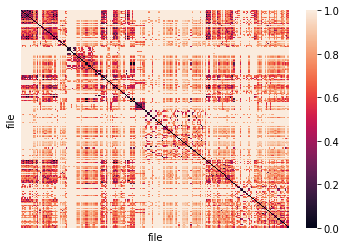

In [20]:
%matplotlib inline
import seaborn as sns

sns.heatmap(
    dissimilarity_df,
    xticklabels=False,
    yticklabels=False
);

Because of the alphabetically ordered filenames and the "feature-first" architecture of the the software under investigation, we get a first glimpse how changes within modules are changed together and which are not.

To get an even better view, we can first extract the module's names with an easy string operation and use this for this indexes.

In [41]:
modules = dissimilarity_df.copy()
modules.index = modules.index.str.split("/").str[6]
modules.index.name = 'module'
modules.columns = modules.index
modules.iloc[25:30,25:30]

module,comment,comment,comment,creator,creator
module,,,,,
comment,0.000000,0.50000,0.750000,0.50000,0.711325
comment,0.500000,0.00000,0.500000,0.00000,0.422650
comment,0.750000,0.50000,0.000000,0.50000,0.711325
creator,0.500000,0.00000,0.500000,0.00000,0.422650
creator,0.711325,0.42265,0.711325,0.42265,0.000000


Then, we can create another heatmap that shows on the name of the modules on the axes for further evaluation.

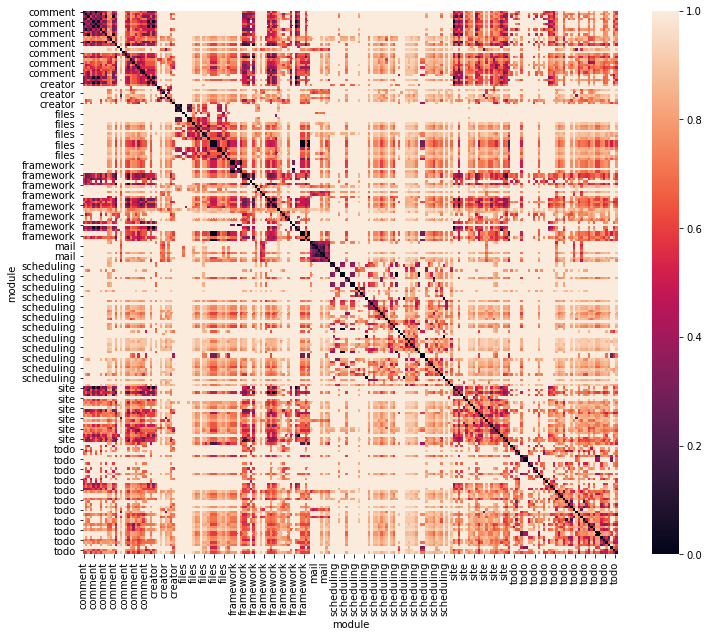

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=[12,10])
sns.heatmap(modules);

**Discussion**

* Starting at the upper left, we see the "comment" module with a pretty dark area very clearly. This means, that files around this module changed together very often.
* If we go down further, we see dark areas between the "comment" module and the "framework" module as well as the "site" module. This shows a hidden change dependency between the "comment" module and the other two. 
* If we take a look in the middle of the heatmap, we see that the very dark area represents changes of the "mail" module. This module was pretty much change without touching any other modules. This shows a nice separation of the responsibility.



## Multi-dimensional scaling
We want to check if the code within the modules is also changed all together (and if not, we want to see why). Here, we can help ourselves with a technique called ["multi-dimensional scaling"](http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html) or "MDS" for short. With MDS, we can break down a n-dimensional space to a lower-dimensional space representation. MDS tries to keep the distance proportions of the higher-dimensional space when breaking it down to a lower-dimensional space.

In our case, we can let MDS figure out a 2D representation of our dissimilarity matrix (which is, overall, just a plain multi-dimensional vector space) to see which files get change together. The machine learning library scikit-learn gives us the algorithm that we need for this task.

In [23]:
from sklearn.manifold import MDS

# uses a fixed seed for random_state for reproducibility
model = MDS(dissimilarity='precomputed', random_state=0)
dissimilarity_2d = model.fit_transform(dissimilarity_df)
dissimilarity_2d[:5]

array([[-0.5259277 ,  0.45070158],
       [-0.56826041,  0.21528001],
       [-0.52746829,  0.34756761],
       [-0.55856713,  0.26202797],
       [-0.4036568 ,  0.49803657]])

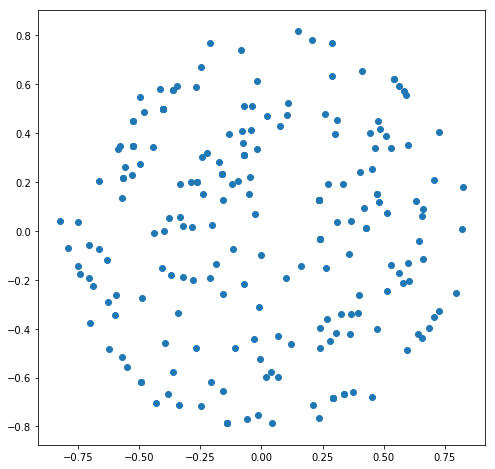

In [24]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

# plot the 2D matrix with colors
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
#plt.scatter(x, y, c=colors)
plt.scatter(x, y)

In [25]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
dissimilarity_2d_df.head()

,0,1
file,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,-0.525928,0.450702
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,-0.568260,0.215280
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,-0.527468,0.347568
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,-0.558567,0.262028
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,-0.403657,0.498037


In [26]:
dissimilarity_2d_df['grouping'] = dissimilarity_2d_df.index.str.split("/").str[6]
dissimilarity_2d_df.head()

,0,1,grouping
file,,,
backend/src/main/java/at/dropover/comment/boundary/AddCommentRequestModel.java,-0.525928,0.450702,comment
backend/src/main/java/at/dropover/comment/boundary/ChangeCommentRequestModel.java,-0.568260,0.215280,comment
backend/src/main/java/at/dropover/comment/boundary/CommentData.java,-0.527468,0.347568,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentRequestModel.java,-0.558567,0.262028,comment
backend/src/main/java/at/dropover/comment/boundary/GetCommentResponseModel.java,-0.403657,0.498037,comment


In [27]:
plot_data = pd.DataFrame(index=dissimilarity_2d_df['grouping'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

grouping
comment       [{'label': 'backend/src/main/java/at/dropover/...
creator       [{'label': 'backend/src/main/java/at/dropover/...
files         [{'label': 'backend/src/main/java/at/dropover/...
framework     [{'label': 'backend/src/main/java/at/dropover/...
mail          [{'label': 'backend/src/main/java/at/dropover/...
scheduling    [{'label': 'backend/src/main/java/at/dropover/...
site          [{'label': 'backend/src/main/java/at/dropover/...
todo          [{'label': 'backend/src/main/java/at/dropover/...
Name: data, dtype: object

In [28]:
import pygal

xy_chart = pygal.XY(stroke=False)

for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
    
xy_chart.render_in_browser()

file://C:/Users/Markus/AppData/Local/Temp/tmpr1tzhalw.html


In [30]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
dissimilarity_2d_df['grouping'] = dissimilarity_2d_df.index.str.split("/").str[6]
plot_data = pd.DataFrame(index=dissimilarity_2d_df['grouping'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
xy_chart = pygal.XY(stroke=False)

for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])

xy_chart.render_to_png("grouping_co-changing_code_tsne.png", dpi=72)
xy_chart.render_to_file('grouping_co-changing_code_tsne.svg')
xy_chart.render_in_browser()

file://C:/Users/Markus/AppData/Local/Temp/tmpci3z2nyu.html


In [33]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
dissimilarity_2d_df['grouping'] = dissimilarity_2d_df.index.str.split("/").str[6]
plot_data = pd.DataFrame(index=dissimilarity_2d_df['grouping'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
xy_chart = pygal.XY(stroke=False)

for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])

xy_chart.render_to_png("grouping_co-changing_code.png")
xy_chart.render_to_file('grouping_co-changing_code.svg')
xy_chart.render_in_browser()

file://C:/Users/Markus/AppData/Local/Temp/tmp4kudllz7.html


In [34]:
domains_encoded = pd.factorize(domain_df.index)[0]
domains_encoded[:10]

NameError: name 'domain_df' is not defined

In [ ]:
relative_index = domains_encoded / domains_encoded.max()
colors = [x for x in cm.hsv(relative_index)]
colors[:3]

In [ ]:
plt.figure(figsize=(8,8))
x = dissimilarity_2d[:,0]
y = dissimilarity_2d[:,1]
plt.scatter(x, y, c=colors)

In [ ]:
dissimilarity_2d_df['domain'] = "other"
#dissimilarity_2d_df['domain'] = dissimilarity_2d_df.index.str.split("/").str[6]
dissimilarity_2d_df.head()

In [ ]:
dissimilarity_2d_df = pd.DataFrame(dissimilarity_2d, index=commit_matrix.index)
plot_data = pd.DataFrame(index=dissimilarity_2d_df['domain'])
plot_data['value'] = tuple(zip(dissimilarity_2d_df[0], dissimilarity_2d_df[1]))
plot_data['label'] = dissimilarity_2d_df.index
plot_data['data'] = plot_data[['label', 'value']].to_dict('records')
plot_dict = plot_data.groupby(plot_data.index).data.apply(list)
plot_dict

import pygal
xy_chart = pygal.XY(stroke=False)


for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)


for entry in plot_dict.iteritems():
    xy_chart.add(entry[0], entry[1])
xy_chart.render_in_browser()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)
xy_chart.add()

In [ ]:
import pygal
xy_chart = pygal.XY(stroke=False)
xy_chart.title = 'Grouped co-changing code'
xy_chart.add('A', [{'value': (2,2), 'label': 'two'}, (4,3)])
xy_chart.render_in_browser()